In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

mri_folder = '/content/drive/MyDrive/MRI/mri'
mask_folder = '/content/drive/MyDrive/MRI/masks'


def load_images_and_masks(mri_folder, mask_folder, img_size=(256, 256)):
    mri_images = []
    mask_images = []

    for mri_filename in os.listdir(mri_folder):
        if mri_filename.endswith('.jpg'):
            mri_path = os.path.join(mri_folder, mri_filename)
            mask_path = os.path.join(mask_folder, mri_filename.replace('.jpg', '.png'))


            mri_img = load_img(mri_path, color_mode='grayscale', target_size=img_size)
            mri_img = img_to_array(mri_img) / 255.0


            mask_img = load_img(mask_path, color_mode='grayscale', target_size=img_size)
            mask_img = img_to_array(mask_img) / 255.0

            mri_images.append(mri_img)
            mask_images.append(mask_img)

    return np.array(mri_images), np.array(mask_images)


mri_images, mask_images = load_images_and_masks(mri_folder, mask_folder)


X_train, X_val, y_train, y_val = train_test_split(mri_images, mask_images, test_size=0.2, random_state=42)

In [ ]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Decoder/Downsampling
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Encoder/Upsampling
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model


model = unet()
'''
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()'''
num_classes = 2  # Binary segmentation (background and tumor)
mean_iou = MeanIoU(num_classes=num_classes)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', mean_iou])

In [ ]:
checkpoint = ModelCheckpoint('unet_breast_cancer.h5', monitor='val_loss', save_best_only=True)#for saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=16,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.9972 - loss: 0.4856 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9972 - loss: 0.4790 - mean_io_u_1: 0.4988 - val_accuracy: 0.9977 - val_loss: 0.0675 - val_mean_io_u_1: 0.4988
Epoch 2/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9975 - loss: 0.0369 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9975 - loss: 0.0365 - mean_io_u_1: 0.4988 - val_accuracy: 0.9977 - val_loss: 0.0166 - val_mean_io_u_1: 0.4988
Epoch 3/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.9975 - loss: 0.0134 - mean_io_u_1: 0.4987

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9975 - loss: 0.0134 - mean_io_u_1: 0.4987 - val_accuracy: 0.9977 - val_loss: 0.0091 - val_mean_io_u_1: 0.4988
Epoch 4/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.9975 - loss: 0.0096 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9975 - loss: 0.0095 - mean_io_u_1: 0.4988 - val_accuracy: 0.9977 - val_loss: 0.0063 - val_mean_io_u_1: 0.4988
Epoch 5/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.9976 - loss: 0.0063 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9976 - loss: 0.0063 - mean_io_u_1: 0.4988 - val_accuracy: 0.9977 - val_loss: 0.0051 - val_mean_io_u_1: 0.4988
Epoch 6/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9975 - loss: 0.0051 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9975 - loss: 0.0051 - mean_io_u_1: 0.4988 - val_accuracy: 0.9977 - val_loss: 0.0038 - val_mean_io_u_1: 0.4988
Epoch 7/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9974 - loss: 0.0049 - mean_io_u_1: 0.4987

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9974 - loss: 0.0049 - mean_io_u_1: 0.4987 - val_accuracy: 0.9977 - val_loss: 0.0037 - val_mean_io_u_1: 0.4988
Epoch 8/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.9977 - loss: 0.0040 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9977 - loss: 0.0040 - mean_io_u_1: 0.4988 - val_accuracy: 0.9988 - val_loss: 0.0036 - val_mean_io_u_1: 0.4988
Epoch 9/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.9986 - loss: 0.0036 - mean_io_u_1: 0.4988

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9986 - loss: 0.0036 - mean_io_u_1: 0.4988 - val_accuracy: 0.9990 - val_loss: 0.0030 - val_mean_io_u_1: 0.4988
Epoch 10/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.9990 - loss: 0.0033 - mean_io_u_1: 0.4987

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9990 - loss: 0.0033 - mean_io_u_1: 0.4987 - val_accuracy: 0.9991 - val_loss: 0.0027 - val_mean_io_u_1: 0.4988
Epoch 11/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9990 - loss: 0.0029 - mean_io_u_1: 0.4987

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9990 - loss: 0.0029 - mean_io_u_1: 0.4987 - val_accuracy: 0.9991 - val_loss: 0.0024 - val_mean_io_u_1: 0.4988
Epoch 12/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9989 - loss: 0.0032 - mean_io_u_1: 0.4987 - val_accuracy: 0.9988 - val_loss: 0.0032 - val_mean_io_u_1: 0.4988


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


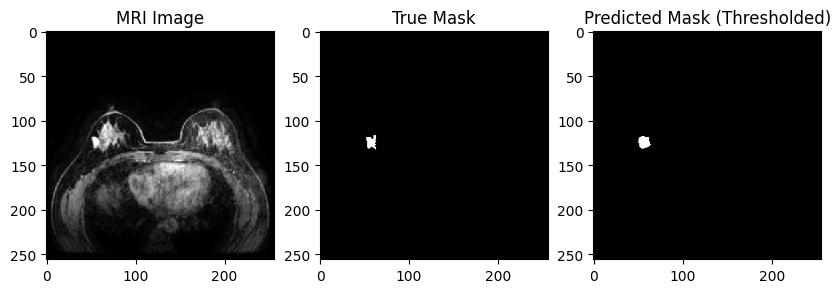

In [ ]:

'''
model.load_weights('unet_breast_cancer.h5')

# Predict on a sample image
sample_image = X_val[1]
sample_mask = y_val[1]

predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('MRI Image')
plt.imshow(sample_image.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('True Mask')
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predicted_mask.squeeze(), cmap='gray')

plt.show()
'''
# Loading the best model
model.load_weights('unet_breast_cancer.h5')

# Predicting on a sample image
sample_image = X_val[12]
sample_mask = y_val[12]

predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

# Apply a threshold (e.g., 0.5)
threshold = 0.3
predicted_mask_binary = (predicted_mask > threshold).astype(np.float32)

# results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('MRI Image')
plt.imshow(sample_image.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('True Mask')
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask (Thresholded)')
plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')

plt.show()